Há 28 colunas de features anonimizadas para cada um dos quase 300.000 transações de cartão de crédito. A coluna Time registra o tempo entre transações em milissegundos. A coluna Amount o montante transferido. A coluna Class diz a label da transação: 1 para fraude e 0 para transação legítima.

In [1]:
from sklearn.preprocessing import RobustScaler
from pyspark.sql import SparkSession
import numpy as np

spark = SparkSession.builder.getOrCreate()

df_cc = spark.read.parquet('spark-warehouse/cc_db').toPandas()

# Escalonamento
df_cc['Amount'] = RobustScaler().fit_transform(df_cc['Amount'].values.reshape(-1, 1))
df_cc['Time'] = RobustScaler().fit_transform(df_cc['Time'].values.reshape(-1, 1))

# Permutação e partição do banco de dados
df_cc = df_cc.reindex(np.random.permutation(df_cc.index))

partitions = [
    int(0.8 * df_cc.shape[0]),
    int(0.9 * df_cc.shape[0])
]

df_train = df_cc.iloc[:partitions[0]]
df_test = df_cc.iloc[partitions[0]:partitions[1]]
df_validate = df_cc.iloc[:partitions[1]]

features = df_cc.columns.to_list()[:-1]
label = ['Class']

22/04/01 20:30:01 WARN Utils: Your hostname, freetoaster resolves to a loopback address: 127.0.1.1; using 192.168.1.98 instead (on interface wlo1)
22/04/01 20:30:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/01 20:30:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/04/01 20:30:11 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [2]:
df_train['Class'].value_counts()

0    227455
1       390
Name: Class, dtype: int64

Dada a disparidade do número de entradas legítimas em comparação com fraudulentas, faz-se necessário uma etapa de reamostragem antes de tirar conclusões sobre os dados.

In [3]:
import pandas as pd

num_frauds = df_train['Class'].sum()
df_cc_copy = df_train.copy().reindex(np.random.permutation(df_train.index))

df_cc_balanced = pd.concat([
    df_cc_copy.loc[df_cc_copy['Class'] == 1],
    df_cc_copy.loc[df_cc_copy['Class'] == 0][:num_frauds]
])

df_cc_balanced = df_cc_balanced.reindex(np.random.permutation(df_cc_balanced.index))

df_cc_balanced['Class'].value_counts()

1    390
0    390
Name: Class, dtype: int64

Observa-se que todos os V features possuem distribuição centrada em 0, desvios padrões entre [0,33; 2,00] e uma grande amplitude de valores, entre [-138; 121].

In [4]:
df_cc_balanced.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,...,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000
mean,0.048927,-2.401939,1.839248,-3.500686,2.298547,-1.557225,-0.677339,-2.844970,0.173672,-1.328482,...,0.356368,0.022168,-0.016087,-0.012211,0.021265,0.011108,0.071560,0.031744,1.143079,0.500000
std,0.566955,5.530409,3.698554,6.187700,3.163338,4.218258,1.782695,6.072114,5.035109,2.341324,...,2.957094,1.243975,1.255849,0.543468,0.673131,0.456909,1.059329,0.419670,3.173205,0.500321
min,-0.990214,-30.552380,-8.402154,-31.103685,-3.540464,-22.105532,-5.773192,-43.557242,-41.044261,-13.434066,...,-22.797604,-8.887017,-19.254328,-2.028024,-4.781606,-1.152671,-7.263482,-3.112369,-0.307413,0.000000
25%,-0.445667,-2.871640,-0.132013,-5.068323,0.012956,-1.803200,-1.466138,-3.184085,-0.240095,-2.331368,...,-0.170061,-0.530459,-0.233307,-0.359541,-0.321845,-0.307698,-0.062989,-0.056962,-0.285370,0.000000
50%,-0.040373,-0.835580,0.983039,-1.397989,1.346344,-0.440262,-0.716418,-0.635219,0.142092,-0.685958,...,0.157226,0.036158,-0.031991,0.030716,0.045745,-0.045215,0.046589,0.034157,-0.055963,0.500000
75%,0.613917,1.027909,2.765175,0.243985,4.289110,0.437812,0.036547,0.290823,0.943403,0.153282,...,0.670739,0.614759,0.195932,0.387075,0.397828,0.306403,0.454884,0.215766,1.089779,1.000000
max,1.025294,2.294711,22.057729,3.151753,12.114672,11.095089,6.474115,8.388032,20.007208,2.820829,...,27.202839,8.361985,5.466230,1.271175,2.208209,1.884741,3.052358,1.521218,26.080207,1.000000


Além da grande disparidade de classe, o banco de dados mostra distribuições diferentes em função da classificação em fraude ou não.

[Text(0.5, 1.0, 'Distribuição do montante pago por classificação'),
 Text(0.5, 0, ''),
 [Text(0, 0, 'Legítima'), Text(1, 0, 'Fraudulenta')],
 Text(0, 0.5, 'Montante')]

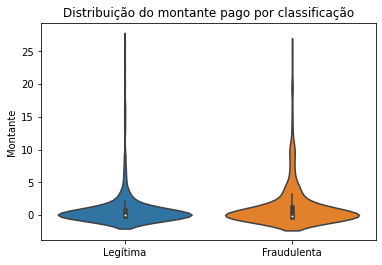

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.violinplot(
    data = df_cc_balanced,
    x = 'Class',
    y = 'Amount',
    scale = 'width'
)\
    .set(
        title = 'Distribuição do montante pago por classificação',
        xlabel = None,
        xticklabels = ['Legítima', 'Fraudulenta'],
        ylabel = 'Montante'
    )

O gráfico de violino mostra que a maior parte dos pagamentos são de pequeno valor. As transações legítimas possuem uma dispersão maior que fraudulentas.

[Text(0.5, 1.0, 'Distribuição temporal por classe'),
 Text(0.5, 0, ''),
 [Text(0, 0, 'Legítima'), Text(1, 0, 'Fraudulenta')],
 Text(0, 0.5, 'Tempo da transação')]

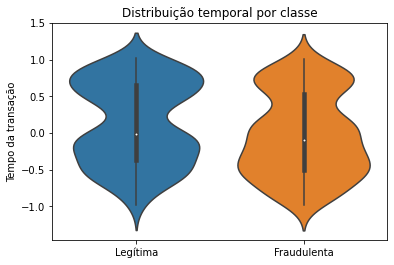

In [6]:
sns.violinplot(
    data = df_cc_balanced,
    x = 'Class',
    y = 'Time'
)\
    .set(
        title = 'Distribuição temporal por classe',
        xlabel = None,
        xticklabels = ['Legítima', 'Fraudulenta'],
        ylabel = 'Tempo da transação'
    )

Esse outro gráfico de violino mostra que ambas as classes tendem a ser bimodais.

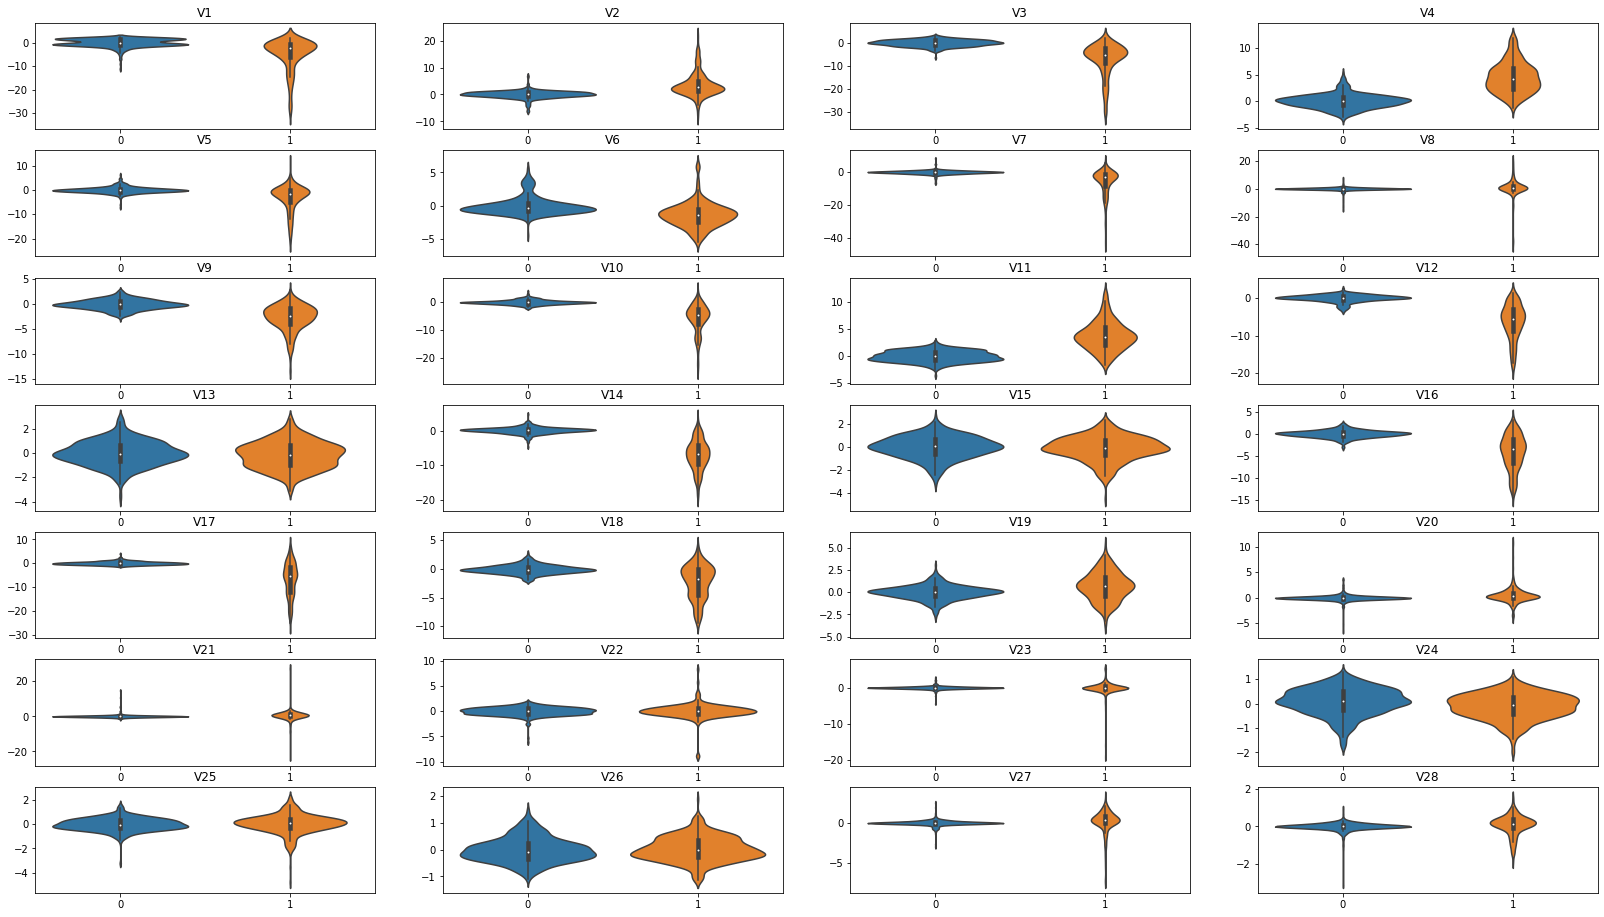

In [7]:
features.remove('Amount')
features.remove('Time')

grid_shape = (7, 4)

features = np.reshape(np.array(features), grid_shape)

fig, axs = plt.subplots(
    nrows = grid_shape[0],
    ncols = grid_shape[1],
    figsize = (4 * grid_shape[0], 4 * grid_shape[1])
)

for i in range(grid_shape[0]):
    for j in range(grid_shape[1]):
        sns.violinplot(
            data = df_cc_balanced,
            x = 'Class',
            y = features[i, j],
            ax = axs[i, j]
        )\
            .set(
                title = features[i, j],
                xlabel = None,
                ylabel = None
            )

Os gráficos de violino deixam claro que há diferenças nas distribuições de label dentre os features. A seguir, se determina quais features são mais importantes para o treinamento do modelo, dessa forma poupando recursos computacionais que seriam desperdiçados em features que pouco contribuiriam para a classificação de clientes.

Text(0.56, 17, 'Correlação de corte')

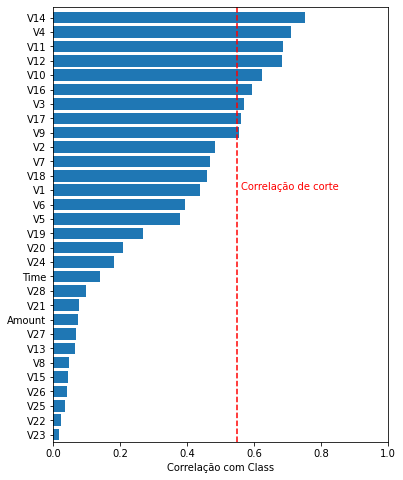

In [8]:
correlation_matrix = df_cc_balanced.corr()
corr_class = correlation_matrix.sort_values('Class', key = lambda x: abs(x))['Class'].iloc[:-1]
corr_class_labels = corr_class.index

fig, ax = plt.subplots(figsize = (6, 8))

ax.barh(
    corr_class_labels,
    abs(corr_class)
)
ax.axvline(0.55, ls = '--', color = 'red')

ax.set_xlabel('Correlação com Class')
ax.set_xlim(xmin = 0, xmax = 1)
ax.set_ylim(ymin = -0.50, ymax = 29.75)
ax.text(
    0.56,
    17,
    'Correlação de corte',
    color = 'red'
)

In [9]:
corr_choice = abs(correlation_matrix.loc['Class']) >= 0.55
training_features = correlation_matrix.loc[corr_choice]['Class'].index.to_list()
training_features

['V3', 'V4', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'Class']

Tomando correlações maiores ou iguais à 0,55, escolhe-se os features `V3`, `V4`, `V9`, `V10`, `V11`, `V12`, `V14`, `V16` e `V17`.

In [10]:
dbs = [
    [spark.createDataFrame(df_cc_balanced[training_features]), 'db_cc_train'],
    [spark.createDataFrame(df_test[training_features]), 'db_cc_test'],
    [spark.createDataFrame(df_validate[training_features]), 'db_cc_validate']
]

for db in dbs:
    db[0].write.format('parquet').saveAsTable(db[1])

22/04/01 20:30:46 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
22/04/01 20:30:47 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
22/04/01 20:30:48 WARN TaskSetManager: Stage 4 contains a task of very large size (2671 KiB). The maximum recommended task size is 1000 KiB.
22/04/01 20:30:48 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
